## Start with the necessary imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf

## Dataset import



In [2]:
import torch
#NOTE invert channel position for keras w.r.t pytorch
train_data_torch = torch.load('../UltraWood/data/databases/train_data_torch_main.pt').float()
train_data_torch = (train_data_torch-torch.mean(train_data_torch,2,keepdim=True))/torch.max(train_data_torch,2,keepdim=True)[0]    
train_data_tf = tf.convert_to_tensor(train_data_torch.permute(0,2,1).numpy())
train_targets_torch = torch.load('../UltraWood/data/databases/train_targets_torch_main.pt')
train_targets_tf = tf.convert_to_tensor(train_targets_torch.numpy())

test_data_torch = torch.load('../UltraWood/data/databases/test_data_torch_main.pt').float()
test_data_torch = (test_data_torch-torch.mean(test_data_torch,2,keepdim=True))/torch.max(test_data_torch,2,keepdim=True)[0]    
test_data_tf = tf.convert_to_tensor(test_data_torch.permute(0,2,1).numpy())
test_targets_torch = torch.load('../UltraWood/data/databases/test_targets_torch_main.pt')
test_targets_tf = tf.convert_to_tensor(test_targets_torch.numpy())

valid_data_torch = torch.load('../UltraWood/data/databases/valid_data_torch_main.pt').float()
valid_data_torch = (valid_data_torch-torch.mean(valid_data_torch,2,keepdim=True))/torch.max(valid_data_torch,2,keepdim=True)[0]    
valid_data_tf = tf.convert_to_tensor(valid_data_torch.permute(0,2,1).numpy())
valid_targets_torch = torch.load('../UltraWood/data/databases/valid_targets_torch_main.pt')
valid_targets_tf = tf.convert_to_tensor(valid_targets_torch.numpy())

print(f"Train X shape {train_data_tf.shape}, Train Y shape {train_targets_tf.shape}\nTest X shape {test_data_tf.shape}, Test Y shape {test_targets_tf.shape}")
print(f"Valid X shape {valid_data_tf.shape}, Test Y shape {valid_targets_tf.shape}")

C:\Users\masg\Anaconda3\envs\hls4ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train X shape (17140, 35000, 1), Train Y shape (17140,)
Test X shape (709, 35000, 1), Test Y shape (709,)
Valid X shape (4297, 35000, 1), Test Y shape (4297,)


In [3]:
'''
batch_size = 1024

train_data = train_data_tf.shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))

val_data = test_data_tf.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)
'''
classes = ["dry", "semi", "wet"]

#train_data_tf = train_data_tf.reshape([train_data_tf.shape[0], train_data_tf.shape[2], 1])
#train_targets_tf = train_targets_tf.reshape([train_targets_tf.shape[0], train_targets_tf.shape[2], 1])
train_targets_tf = tf.keras.utils.to_categorical(train_targets_tf, num_classes=len(classes))
test_targets_tf = tf.keras.utils.to_categorical(test_targets_tf, num_classes=len(classes))
valid_targets_tf = tf.keras.utils.to_categorical(valid_targets_tf, num_classes=len(classes))


## Defining the model

We then need to define a model. For the lowest possible latency, each layer should have a maximum number of trainable parameters of 4096. This is due to fixed limits in the Vivado compiler, beyond which maximally unrolled (=parallel) compilation will fail. This will allow us to use `strategy = 'latency'` in the hls4ml part, rather than `strategy = 'resource'`, in turn resulting in lower latency

In [4]:
from tensorflow.keras.layers import Conv1D, AvgPool1D, ReLU, Flatten, Dense, Softmax

In [5]:
model = tf.keras.Sequential()
model.add(Conv1D(filters=32, kernel_size=128, strides=32, input_shape=(35000, 1)))
model.add(ReLU())
model.add(AvgPool1D(pool_size=2, strides=2))
model.add(Conv1D(filters=32, kernel_size=64, strides=16))
model.add(ReLU())
model.add(AvgPool1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(9))
model.add(ReLU())
model.add(Dense(3, name='output_dense'))
model.add(Softmax(name="output_softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1090, 32)          4128      
                                                                 
 re_lu (ReLU)                (None, 1090, 32)          0         
                                                                 
 average_pooling1d (AverageP  (None, 545, 32)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 32)            65568     
                                                                 
 re_lu_1 (ReLU)              (None, 31, 32)            0         
                                                                 
 average_pooling1d_1 (Averag  (None, 15, 32)           0         
 ePooling1D)                                            

Lets check if this model can be implemented completely unrolled (=parallel)

In [6]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv1D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))

conv1d: 4096
conv1d_1: 65536
Layer conv1d_1 is too large (65536), are you sure you want to train?
dense: 4320
Layer dense is too large (4320), are you sure you want to train?
output_dense: 27


Looks good! It's below the Vivado-enforced unroll limit of 4096.

## Prune dense and convolutional layers
Since we've seen in the previous notebooks that pruning can be done at no accuracy cost, let's prune the convolutional and dense layers to 50% sparsity, skipping the output layer

In [14]:
batch_size = 32

In [15]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks


NSTEPS = int(train_data_tf.shape[0]*0.9)  // batch_size #90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))

# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs, 
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.0,
                                                                   final_sparsity = 0.50, 
                                                                   begin_step = NSTEPS*2, 
                                                                   end_step = NSTEPS*10, 
                                                                   frequency = NSTEPS)
                     }
    if isinstance(layer, tf.keras.layers.Conv1D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

model_pruned = tf.keras.models.clone_model( model, clone_function=pruneFunction)

Number of training steps per epoch is 482


## Train baseline

We're now ready to train the model! We defined the batch size and n epochs above. We won't use callbacks that store the best weights only, since this might select a weight configuration that has not yet reached 50% sparsity.

In [16]:
train = False # True if you want to retrain, false if you want to load a previsously trained model

n_epochs = 10

if train:
    
    LOSS        = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=3e-3)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1)
            ] 

    start = time.time()
    model.fit(x=train_data_tf,
                     y=train_targets_tf,
                     batch_size=batch_size,
                     validation_data=(valid_data_tf, valid_targets_tf),
                     epochs = n_epochs,
                     callbacks = callbacks)   
    end = time.time()

    print('It took {} minutes to train Keras model'.format( (end - start)/60.))
    
    model.save('cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('cnn_model.h5', custom_objects=co)

In [18]:
train = True # True if you want to retrain, false if you want to load a previsously trained model

n_epochs = 30

if train:
    
    LOSS        = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=3e-3)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1),
            pruning_callbacks.UpdatePruningStep()
            ] 

    start = time.time()
    model_pruned.fit(x=train_data_tf,
                     y=train_targets_tf,
                     batch_size=batch_size,
                     validation_data=(valid_data_tf, valid_targets_tf),
                     epochs = n_epochs,
                     callbacks = callbacks)   
    end = time.time()

    print('It took {} minutes to train Keras model'.format( (end - start)/60.))
    
    model_pruned.save('pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30
536/536 [==============================] - 12s 14ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 7.3945e-04 - val_accuracy: 1.0000 - lr: 0.0030
Epoch 2/30
536/536 [==============================] - 7s 13ms/step - loss: 6.2391e-04 - accuracy: 1.0000 - val_loss: 5.4686e-04 - val_accuracy: 1.0000 - lr: 0.0030
Epoch 3/30
536/536 [==============================] - 7s 13ms/step - loss: 4.5283e-04 - accuracy: 1.0000 - val_loss: 4.0371e-04 - val_accuracy: 1.0000 - lr: 0.0030
Epoch 4/30
536/536 [==============================] - 7s 14ms/step - loss: 3.2826e-04 - accuracy: 1.0000 - val_loss: 2.9839e-04 - val_accuracy: 1.0000 - lr: 0.0030
Epoch 5/30
536/536 [==============================] - 6s 11ms/step - loss: 2.4528e-04 - accuracy: 1.0000 - val_loss: 2.1936e-04 - val_accuracy: 1.0000 - lr: 0.0030
Epoch 6/30
536/536 [==============================] - 7s 14ms/step - loss: 1.7734e-04 - accuracy: 1.0000 - val_loss: 1.6328e-04 - val_accuracy: 1.0000 - lr: 0.0030
Epoch 7/30
536/536 

In [20]:
test_score_baseline = model_pruned.evaluate(test_data_tf, test_targets_tf)
print('Keras accuracy = {}'.format(test_score_baseline[1]))

23/23 [==============================] - 0s 17ms/step - loss: 75.7289 - accuracy: 0.0000e+00
Keras accuracy = 0.0


In [21]:
from sklearn.metrics import confusion_matrix

y_prediction = model.predict(test_data_tf)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test = np.argmax(test_targets_tf, axis=1)
#Create confusion matrix 
result = confusion_matrix(y_test, y_prediction)
print(result)

23/23 [==============================] - 0s 11ms/step
[[  0   0   0]
 [532   0   0]
 [177   0   0]]


In [22]:
for pred, gt in zip(y_prediction,y_test):
    print(pred, gt)

0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1


Layer conv1d: % of zeros = 0.0
Layer conv1d_1: % of zeros = 0.0
Layer dense: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


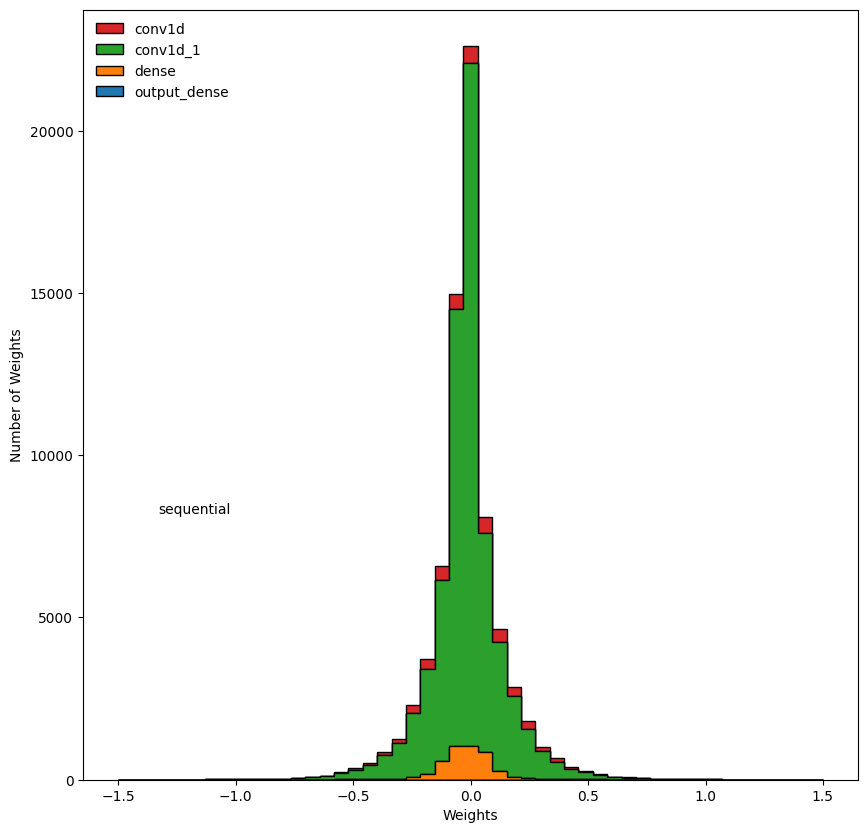

In [23]:
def doWeights(model):

    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch")!=-1 or len(layer.get_weights())<1:
            continue 
        weights=layer.weights[0].numpy().flatten()  
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name,np.sum(weights==0)/np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10,10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW,bins,histtype='stepfilled',stacked=True,label=labelsW, edgecolor='black')
    plt.legend(frameon=False,loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38,model._name, wrap=True, horizontalalignment='left',verticalalignment='center')
    
doWeights(model_pruned) 

## CNNs in hls4ml

In this part, we will take the two models we trained above (the floating-point 32 Keras model and the 6-bit QKeras model), and synthesize them with hls4ml. Although your models are probably already in memory, let's load them from scratch. We need to pass the appropriate custom QKeras/pruning layers when loading, and remove the pruning parameters that were saved together with the model.

In [24]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = tf.keras.models.load_model('pruned_cnn_model.h5',custom_objects=co)
model  = strip_pruning(model)


Now, we need to define the hls4ml and Vivado configurations. Two things will change with respect to what was done in the previous exercises. First, we will use ``IOType= 'io_stream'`` in the Vivado configuration.

---
****You must use ``IOType= 'io_stream'`` if attempting to synthesize a convolutional neural network.****

---
The CNN implementation in hls4ml is based on streams, which are synthesized in hardware as first in, first out (FIFO) buffers. Shift registers are used to keep track of the last  ``<kernel height - 1>`` rows of input pixels, and maintains a shifting snapshot of the convolution kernel.

This is illustrated  in the gif below. Here, the input image is at the top-left and the output image at the bottom left. The top right image shows the internal state of the shift registers and convolutional kernel. The red square indicates the current pixels contained within the convolutional kernel.

![alt text](images/conv2d_animation.gif "The implementation of convolutional layers in hls4ml.")

Lastly, we will use ``['Strategy'] = 'Latency'`` for all the layers in the hls4ml configuration. If one layer would have >4096 elements, we sould set ``['Strategy'] = 'Resource'`` for that layer, or increase the reuse factor by hand. You can find examples of how to do this below.

In [26]:
import hls4ml
import plotting

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

#First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 4

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' 
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation 
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 4
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['KerasModel'] = model
cfg['OutputDir']  = 'pruned_cnn/'
cfg['XilinxPart'] = "xc7z020clg400-1"
  
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: conv1d_input, layer type: Input
Layer name: conv1d, layer type: Conv1D
  -> Activation (linear), layer name: conv1d
Layer name: re_lu, layer type: ReLU
Layer name: average_pooling1d, layer type: AveragePooling1D
Layer name: conv1d_1, layer type: Conv1D
  -> Activation (linear), layer name: conv1d_1
Layer name: re_lu_1, layer type: ReLU
Layer name: average_pooling1d_1, layer type: AveragePooling1D
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
Layer name: re_lu_2, layer type: ReLU
Layer name: output_dense, layer type: Dense
  -> Activation (linear), layer name: output_dense
Layer name: output_softmax, layer type: Softmax
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       4
  Strategy:          Latency
LayerName
  conv1d_input
    Precision
      result:        ap_fixed<16,6>
    Strategy:        Resource
    ReuseFactor:     4
  conv1d
    Precision
      weight:        ap_fixed<16,6>
      bias:

Exception: Failed to compile project "myproject"

Let's get a nice overview over the various shapes and precisions used for each layer through ``hls4ml.utils.plot_model``, as well as look at the weight profile using ``hls4ml.model.profiling.numerical``. The weight profiling returns two plots: Before (top) and after (bottom) various optimizations applied to the HLS model before the final translation to HLS, for instance the fusing of Dense and BatchNormalization layers.

In [ ]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)

The colored boxes are the distribution of the weights of the model, and the gray band illustrates the numerical range covered by the chosen fixed point precision. As we configured, this model uses a precision of ``ap_fixed<16,6>`` for all layers of the model. Let's now build our QKeras model

### Accuracy with bit-accurate emulation 
Let's check that the hls4ml accuracy matches the original. This usually takes some time, so let's do it over a reduced dataset

In [ ]:
X_test_reduced = test_data_tf[:3000]
Y_test_reduced = test_targets_tf[:3000]

In [ ]:
y_predict        = model.predict(X_test_reduced)
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(X_test_reduced))

In [ ]:
import plotting
from sklearn.metrics import accuracy_score

def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    
    accuracy_keras  = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred,axis=1)))
    accuracy_hls4ml = float(accuracy_score (np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1)))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(9, 9))
    _ = plotting.makeRoc(Y, y_pred, labels=['%i'%nr for nr in range(n_classes)])
    plt.gca().set_prop_cycle(None) # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, labels=['%i'%nr for nr in range(n_classes)], linestyle='--')

    from matplotlib.lines import Line2D
    lines = [Line2D([0], [0], ls='-'),
             Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend
    leg = Legend(ax, lines, labels=['Keras', 'hls4ml'],
                loc='lower right', frameon=False)
    ax.add_artist(leg)
    plt.figtext(0.2, 0.38,label, wrap=True, horizontalalignment='left',verticalalignment='center')
    plt.ylim(0.01,1.)
    plt.xlim(0.7,1.)

# Plot the pruned floating point model:    
plotROC(Y_test_reduced,y_predict,y_predict_hls4ml,label="Keras") 

Looks good! Let's synthesize the models. 
## Logic synthesis
This takes quite a while for CNN models, up to one hour for the models considered here. In the interest of time, we have therefore provided the neccessary reports for the models considered. You can also synthesize them yourself if you have time, and as usual follow the progress using ``tail -f pruned_cnn/vivado_hls.log`` and ``tail -f quantized_pruned_cnn/vivado_hls.log``.


In [ ]:
synth = False # Only if you want to synthesize the models yourself (>1h per model) rather than look at the provided reports.
if synth:
    hls_model.build(csim=False, synth=True, vsynth=True)

We extract the latency from the C synthesis, namely the report in ```<project_dir>/myproject_prj/solution1/syn/report/myproject_csynth.rpt```. A more accurate latency estimate can be obtained from running cosim by passing ```hls_model.build(csim=False, synth=True, vsynth=True, cosim=True)``` ( = C/RTL cosimulation, synthesised HLS code is run on a simulator and tested on C test bench) but this takes a lot of time so we will skip it here.
The resource estimates are obtained from the Vivado logic synthesis, and can be extracted from the report in ```<project_dir>/vivado_synth.rpt```. Let's fetch the most relevant numbers:

In [ ]:
def getReports(indir):
    data_ = {}
    
    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))
    
    if report_vsynth.is_file() and report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))
        
        # Get the resources from the logic synthesis report 
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            data_['lut']     = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
            data_['ff']      = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            data_['bram']    = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp']     = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            data_['lut_rel'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5])
            data_['ff_rel']  = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])
            data_['bram_rel']= float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
            data_['dsp_rel'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])
        
        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            data_['latency_mus']  = float(lat_line.split('|')[2])*5.0/1000.
            data_['latency_ii']   = int(lat_line.split('|')[6])
    
    return data_

In [ ]:
from pathlib import Path
import pprint 

data_pruned_ref = getReports('pruned_cnn')

print("\n Resource usage and latency: Pruned")
pprint.pprint(data_pruned_ref)